1.LSTM层的输入 <br/>
batchsize:每批多少个序列 <br/>
sequence_length:序列长度（步长） <br/>
number_features:特征个数 <br/>
2.LSTM层的输出 <br/>
batchsize:每批多少个序列 <br/>
sequence_length:序列长度（步长） <br/>
hidden_size:隐藏节点的node数 <br/>
3.Linear层的输入 <br/>
batches:有多少个batch_size<br/>
n_hidden:隐藏层节点的node数<br/>
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM

In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
#定义网络
class lstm_model(nn.Module):
    def __init__(self,vocab,hidden_size,num_layers,dropout=0.5):
        super(lstm_model,self).__init__()
        self.vocab = vocab #字符数据集
        #索引:字符
        #self.int_char = dict(enumerate(vocab))
        self.int_char = {i:char for i,char in enumerate(vocab)}
        #字符：索引
        self.char_int = {char:i for i,char in self.int_char.items()}
        #对字符进行one-hot encoding
        self.encoder = OneHotEncoder(sparse=False).fit(vocab.reshape(-1,1))#对vocab进行shape转换
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        #lstm层
        self.lstm = nn.LSTM(len(vocab),hidden_size,num_layers,batch_first=True,dropout=dropout)
        #全连接层
        self.linear = nn.Linear(hidden_size,len(vocab)) #这里输出的shape是每个字符的得分
        
    def forward(self,sequence,hs=None):
        out,hs = self.lstm(sequence,hs) #lstm输出 batch_size,sequence_length ,hidden_size
        out = out.reshape(-1,self.hidden_size) #out转化为linear的输入格式,-1是为了让其中的两个输出相乘
        output = self.linear(out) #全连接层输出 batch_size*sequence_length,vocab_size
        return output,hs
    
    def onehot_encode(self,data):
        return self.encoder.transform(data)
    def onehot_decode(self,data):
        return self.encoder.inverse_transform(data)
    def label_encode(self,data):
        return np.array([self.char_int[ch] for ch in data])
    def label_decode(self,data):
        return np.array([self.int_char[ch] for ch in data])

In [3]:
#定义构建新数据集的批量处理方法
def get_batches(data,batch_size,seq_len):
    num_features = data.shape[1]#数据的列数，即特征数
    num_chars = batch_size * seq_len #一个batch_size的字符数量
    num_batches = int(np.floor(len(data)/num_chars)) #计算出有多少个batches,余数直接舍去
    need_chars = num_batches * num_chars  #根据batch_size和batches 计算出所需的总字符数量，舍去余数之后的
    
    targets = np.append(data[1:],data[0]).reshape(data.shape) #标签数据，标签全往后挪一位
    
    inputs = data[:need_chars] #从原始数据data1中截取所需的字符数量need_chars
    targets = targets[:need_chars] #从原始标签target中截取所需的字符数量need_words
    
    #shape转换
    inputs = inputs.reshape(batch_size,-1,num_features)
    targets = targets.reshape(batch_size,-1,num_features)
    
    #构建新的数据集
    for i in range(0,inputs.shape[1],seq_len):
        x = inputs[:,i:i+seq_len]
        y = targets[:,i:i+seq_len]
        yield x,y

In [4]:
#定义训练函数
def train(model,data,batch_size,seq_len,epochs,lr=0.01,valid=None):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()
    if valid is not None:
        data = model.onehot_encode(data.reshape(-1,1))
        valid = model.onehot_encode(valid.reshape(-1,1))
    else:
        data = mode.onehot_encode(data.reshape(-1,1))
    #保存损失值
    train_loss = []
    val_loss = []
    #循环训练（验证）
    for epoch in range(epochs):
        model.train()
        hs = None
        train_ls = 0.0
        val_ls = 0.0
        for x,y in get_batches(data,batch_size,seq_len):
            optimizer.zero_grad()
            x = torch.tensor(x).float().to(device)
            out, hs = model(x,hs)
            hs = ([h.data for h in hs]) #读取每一个hidden_size的结点
            #对targets的one-hot encoding 进行逆向转换
            y = y.reshape(-1,len(model.vocab))
            y = model.onehot_decode(y)
            y = model.label_encode(y.squeeze())
            #类型转换
            y = torch.from_numpy(y).long().to(device) #float类型会报错，要long
            
            loss = criterion(out,y.squeeze())
            loss.backward()
            
            optimizer.step()
            
            train_ls += loss.item()
        
        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x,y in get_batches(valid,batch_size,seq_len):
                    x = torch.tensor(x).float().to(device)
                    out,hs = model(x,hs)
                    hs = ([h.data for h in hs])
                    
                    y = y.reshape(-1,len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)
                    
                    loss = criterion(out,y.squeeze())
                    val_ls += loss.item()
                
                val_loss.append(np.mean(val_ls)) #求出每一轮的损失均值
            
            train_loss.append(np.mean(train_ls))
        
        print(f'--------------Epochs{epochs} | {epoch}---------------')
        print(f'Train Loss : {train_loss[-1]}') # 这里-1为最后添加进去的loss值，即本轮batch的loss
        if val_loss:
            print(f'Val Loss : {val_loss[-1]}')
    
    # 绘制loss曲线
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [5]:
#获取数据
with open("anna.txt") as data:
    text = data.read()

In [6]:
#显示前100的字符
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [7]:
#筛选出文本数据中不同的字符
vocab = np.array(sorted(set(text)))

vocab

array(['\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')', '*', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
       'X', 'Y', 'Z', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
       'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [8]:
vocab_size = len(vocab)
val_len = int(np.floor(0.2*len(text)))


In [9]:
trainset = np.array(list(text[:-val_len]))
validset = np.array(list(text[-val_len:]))

print(trainset.shape)
print(validset.shape)

(1588179,)
(397044,)


In [10]:
#定义超参数
hidden_size = 256
num_layers = 2
batch_size = 128
seq_len = 100
epochs = 3
lr = 0.01

model = lstm_model(vocab,hidden_size,num_layers)

model

lstm_model(
  (lstm): LSTM(83, 256, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=256, out_features=83, bias=True)
)

C:\Users\user\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


--------------Epochs3 | 0---------------
Train Loss : 389.0932834148407
Val Loss : 96.908700466156
--------------Epochs3 | 1---------------
Train Loss : 373.9860439300537
Val Loss : 89.67189168930054
--------------Epochs3 | 2---------------
Train Loss : 320.87155413627625
Val Loss : 69.73346543312073


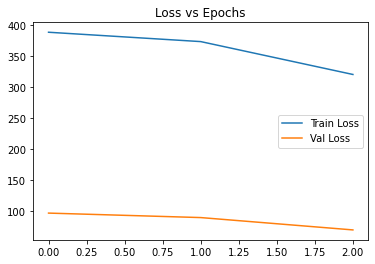

In [11]:
train(model,trainset,batch_size,seq_len,epochs,lr=lr,valid=validset)

In [14]:
def predict(model,char,top_k=None,hidden_size = None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    with torch.no_grad():
        char = np.array([char])
        char = char.reshape(-1,1)
        char_encoding = model.onehot_encode(char)
        char_encoding = char_encoding.reshape(1,1,-1)
        char_tensor = torch.tensor(char_encoding, dtype=torch.float32)
        char_tensor = char_tensor.to(device)
        
        out,hidden_size = model(char_tensor,hidden_size)
        
        probs = F.softmax(out,dim=1).squeeze()
        
        if top_k is None:
            indices = np.arange(vocab_size)
        else:
            probs, indices = probs.topk(top_k)
            indices = indices.cpu().numpy()
        
        probs = probs.cpu().numpy()
        
        he = np.sum(probs)
        char_index = np.random.choice(indices,p = probs/ probs.sum()) #随机选取一个索引
        char = model.int_char[char_index] #获取索引对应的字符
        
    return char ,hidden_size

In [16]:
#获取一个样本
def sample(model,length,top_k=None,sentence="every unhappy familt"):
    hidden_size = None
    new_sentence = [char for char in sentence]
    for i in range(length):
        next_char,hidden_size = predict(model,new_sentence[-1],top_k=top_k,hidden_size=hidden_size)
        new_sentence.append(next_char)
    
    return ''.join(new_sentence)

new_text = sample(model, 2000, top_k=5)
new_text

'every unhappy familtifing hurte she here sing, as asd of to astenting on at\nshad\nout and sar sart ons she shite the he tor wete, and son tho thee the sarling he toose soos, whe cald at th her here wat her, we ther, the\nsore whe siss the chersing sher ant ant the he tor sher the woud and thers he sarilore.\nHo shes sotte he hime, war are woring sistere herse sorler thet that that thit all the sangasse the welittes hilg tith and time he ceude has all, and hough sho the than and thet hos on al ho cathens the her thing of he werl, she sith she woun to his the tas thing at an shes ho coud toed and and thit tu ant her seling hat an were to thit the hense wom the wimt her sher the he toot the celing to shim had ard,"" we the\nsist as tore thad an wore\nhit as her, the\nsale the sale there shor wome, as the tint out there and that and of hat seed the hor soon the hussadering she wome sho she hond she san wat he hor with on sar the wittinn he come the carled. "Were ale ther wot ald. I she t

In [18]:
model_name = "lstm_model.net"

checkpoint = {
    'hidden_size' : model.hidden_size,
    'num_layers' : model.num_layers,
    'state_dict' : model.state_dict()
}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)